# With Parameter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/train_qso_wo_image.csv')
df_test = pd.read_csv('../data/train_qso_wo_image.csv')

# Data Processing 

## Scaling

In [3]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
s.fit(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])
data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']] = s.transform(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])

## Train Test Split

In [4]:
X = data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']]

y = data['class_bin']

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [6]:
count_class = pd.DataFrame(y_train.value_counts()).reset_index()
count_class.rename(columns = {'index' : 'class_cleaned','class_cleaned':'occ'},inplace = True)
count_class

,class_cleaned,class_bin
0,1,104
1,0,99


In [7]:
count_class = pd.DataFrame(y_test.value_counts()).reset_index()
count_class.rename(columns = {'index' : 'class_cleaned','class_cleaned':'occ'},inplace = True)
count_class

,class_cleaned,class_bin
0,0,26
1,1,25


# Model with Bayesian optimization

In [8]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200]),
        'class_weight':hp.choice('class_weight',['balanced_subsample','balanced'])}

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'],
                                   class_weight = space['class_weight']
                                 )
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|████████| 80/80 [02:31<00:00,  1.90s/trial, best loss: -0.9357317073170732]


{'class_weight': 0,
 'criterion': 0,
 'max_depth': 1190.0,
 'max_features': 0,
 'min_samples_leaf': 0.007703171100191995,
 'min_samples_split': 0.01102436104457952,
 'n_estimators': 1}

In [9]:
# We can now retrieve the set of best parameters identified and test our model using the best dictionary created during training. 
# Some of the parameters have been stored in the best dictionary numerically using indices, 
# therefore, we need first to convert them back as strings before input them in our Random Forest.

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}
cw = {0:'balanced_subsample',1:'balanced'}
class_weight = {0:'balanced_subsample',1:'balanced'}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X_train,y_train)

predictionforest = trainedforest.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc5 = accuracy_score(y_test,predictionforest)


[[22  4]
 [ 5 20]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        26
           1       0.83      0.80      0.82        25

    accuracy                           0.82        51
   macro avg       0.82      0.82      0.82        51
weighted avg       0.82      0.82      0.82        51



In [22]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predictionforest))
print('F1:', metrics.f1_score(y_test,predictionforest))
print("recall:",metrics.recall_score(y_test, predictionforest))

Accuracy: 0.8235294117647058
F1: 0.816326530612245
recall: 0.8


In [27]:
#generate a no skill prediction
ns_prob = [0 for _ in range(len(y_test))]
#prodict probability
clf_prob = trainedforest.predict_proba(X_test)
# keep probabilities for the positive outcome only/
clf_prob = clf_prob[:, 1]

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc = roc_auc_score(y_test, clf_prob)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.923


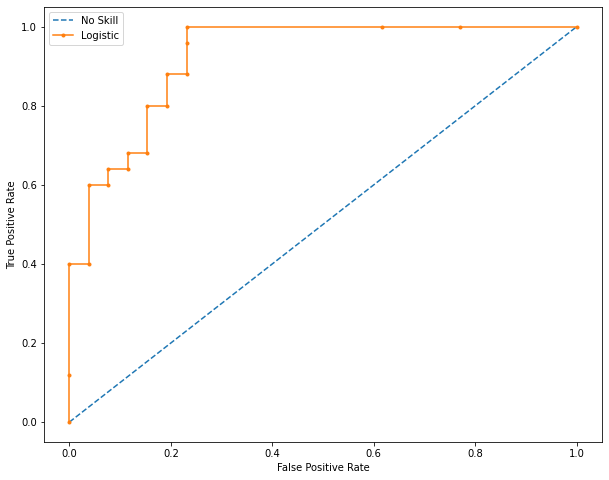

In [24]:
import matplotlib.pyplot as plt
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, clf_prob)


plt.figure(figsize=(10, 8))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig('../figures/rfc_v1_rocauc.png')
# show the plot
plt.show()

In [25]:
trainedforest.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', max_depth=1190.0,
                       min_samples_leaf=0.007703171100191995,
                       min_samples_split=0.01102436104457952, n_estimators=50)>

### pickle the model

In [26]:
import pickle
filename = '../saved_models/rfc_bayesian.sav'
pickle.dump(trainedforest,open(filename,'wb'))

loaded_model = pickle.load(open(filename,'rb'))

- value = [67.5,67.5] describes the repartition of these objects between the two class: 67.5 for non quasars and 67.5 for quasars

## Metrics Output

In [49]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predictionforest))
print('F1:', metrics.f1_score(y_test,predictionforest))
print("recall:",metrics.recall_score(y_test, predictionforest))

Accuracy: 0.803921568627451
F1: 0.7916666666666667
recall: 0.76


In [13]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictionforest)
cf_matrix

array([[10,  1],
       [ 2, 26]])

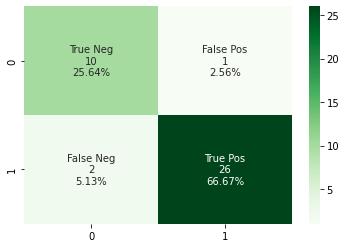

In [14]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

plt.savefig('../figures/rfc_p_cf_matrix')

In [19]:
feature_imp = pd.Series(trainedforest.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

ij            0.097950
rw1           0.067388
uk            0.052833
gk            0.046485
zj            0.046198
iw2           0.045840
rw2           0.041804
gw1           0.037731
ik            0.036614
zw2           0.035647
iw1           0.035097
rz            0.034488
jw2           0.033263
w1w2          0.031914
iz            0.031790
zw1           0.030304
uj            0.028269
petroR50_r    0.025000
kw2           0.024388
ur            0.022365
ug            0.022268
zk            0.020169
gz            0.019750
ui            0.019370
ri            0.017089
uz            0.015230
uw2           0.014911
gw2           0.013758
gr            0.013261
uw1           0.010573
kw1           0.008359
petroR50_g    0.008041
jw1           0.007428
gi            0.004424
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


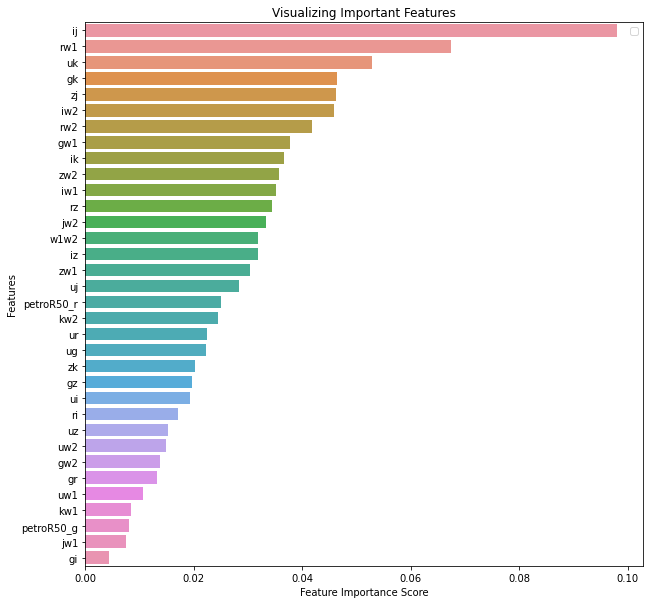

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10, 10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.savefig('../figures/rfc_v1_features.png')
plt.show()



When the depth of the tree = 6, the model starts to overfitting a bit. But overall, not a really big problem

In [ ]:
train_scores, test_scores = list(), list()

# define the tree depths to evaluate
values = [i for i in range(1, 1000,10)]
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = i, 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']])
    # fit model on the training dataset
    model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

## Visualization of the model

In [45]:
#picking one tree from the clf model
estimator = trainedforest.estimators_[1]

target_names = ['non_quasar','quasars']

from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Discussion

In [17]:
df = pd.read_csv('../data/train_qso.csv')

<AxesSubplot:xlabel='ij', ylabel='Count'>

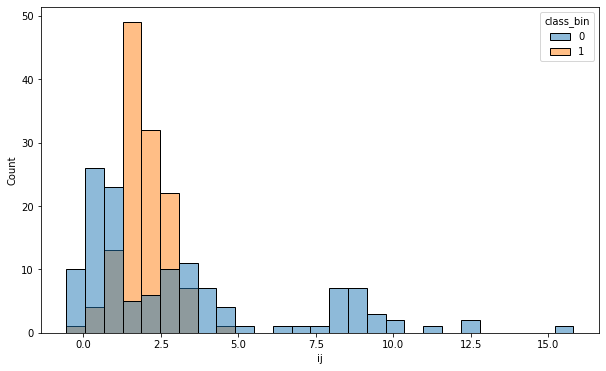

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="ij", hue="class_bin")

<AxesSubplot:xlabel='gk', ylabel='Count'>

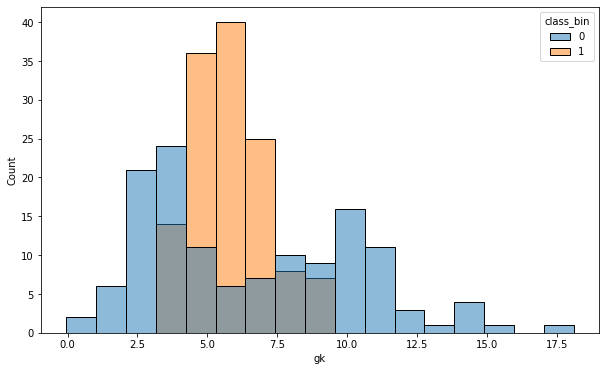

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gk", hue="class_bin")

<AxesSubplot:xlabel='gw1', ylabel='Count'>

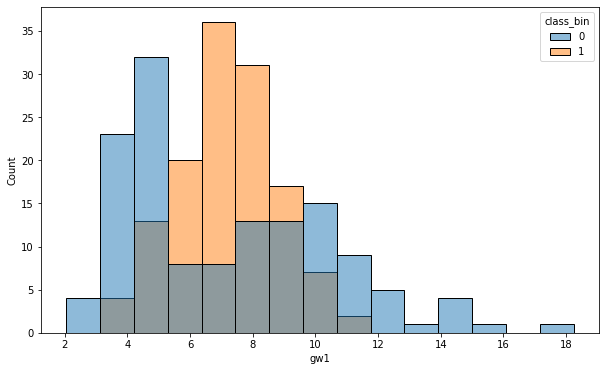

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gw1", hue="class_bin")